After training, we test the network by loading it, forwarding data to it and how to extract features maps.

In [1]:
from astropy.io import fits as fits
from matplotlib import pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize']=[12,8]


In [2]:
matplotlib.rcParams['figure.figsize']=[12,8]


In [3]:
## Set up the sys.path in order to be able to import our modules
import os
import sys
module_path = os.path.abspath(os.path.join('../python'))
if module_path not in sys.path:
    sys.path.append(module_path)

First, you can load a model using load_model from Keras to load an hdf5 file containing a network (saved using save_model or a ModelCheckpoint also defined in Keras).

Otherwise, using the DeepNet class, you can call the constructor with the file.

In [4]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as backk

###################################
# TensorFlow wizardry
config = tf.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
# This line is optional, don't add it unless you really need to set a limit on the memory available for your process
# For instance, if you want to train 2 DNNs on the same GPU without one overlapping the memory needed by the other
# Change the value to set the percentage of memory allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.47 

# Create a session with the above options specified.
backk.tensorflow_backend.set_session(tf.Session(config=config))

# Now you can create/load your DNN

Using TensorFlow backend.


The following is some helper code.

In [5]:
"""
Based on code written by alechat
"""

import os
import numpy as np
from subprocess import Popen, PIPE

def fits2npy(fits_file, idx_hdu):
    '''Read .fits containing the psf'''
    data = fits.getdata(fits_file, idx_hdu)
    nb_gal_row = data.shape[0]//96
    data_list = []
    idx_list = range(0, 10000)
    for i in idx_list:
        y = (96*i)%(nb_gal_row*96)
        x = i//nb_gal_row * 96
        data_list.append(data[x:x+96,y:y+96])
    return np.asarray(data_list)

def StampCollection2Mosaic(stamplist,gal_dim=96,nb_gal=10000):
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    mosaic=np.empty((nb_gal_row*gal_dim,nb_gal_row*gal_dim))
    for i in range(nb_gal):
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        mosaic[x:x+gal_dim,y:y+gal_dim]=stamplist[i,:,:,0]
    return mosaic   

def compute_pixel_error(target_file, hdu_target, reconst_file, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1)):
    '''
    X: ground truth
    Y: estimated images
    '''
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    X = fits.getdata(target_file,hdu_target)
    Y = fits.getdata(reconst_file)
    DIFF=X-Y
    err = []
    for i in range(nb_gal):
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        if gal_dim == 96:
            err.append((np.linalg.norm((DIFF[x:x+gal_dim,y:y+gal_dim])[xslice, 
                        yslice])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim][xslice, yslice])**2))
        else:
            err.append((np.linalg.norm(DIFF[x:x+gal_dim,y:y+gal_dim])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim])**2))
    return err

def generate_shape_txt(gal_file, psf_file,output_file, cmd_file='get_shape.cmd', gal_dim=96, mosaic_size=100, save_weights='', weights_input=''):
    #print('Computing ellipticity for file: %s'%(gal_file))
    #print('Saving result in: %s'%(output_file))
    executable = '/data/shapelens_v2/shapelens-CEA-master/bin/get_shapes'
    if weights_input in '-o-i':
        cmd = '%s %s %s -p %s -g %d -s %d -T %s | tee %s'%(executable, weights_input, save_weights, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    else:
        cmd = '%s -p %s -g %d -s %d -T %s | tee %s'%(executable, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    print(cmd)
    try:
        os.remove(cmd_file)
    except OSError:
        pass
    f = open(cmd_file, 'w')
    f.write('#! /bin/bash\n')
    f.write('source /home/fsureau/.bashrc\n')
    f.write(cmd)
    f.close()
    os.system('chmod 777 '+cmd_file)
    p = Popen('./'+cmd_file, stdout=PIPE, stderr=PIPE)
    stdout, stderr = p.communicate()
    return stdout, stderr

def fast_generate_shape_txt(gal_file, psf_file,output_file, cmd_file='get_shape.cmd', gal_dim=96, mosaic_size=100, save_weights='', weights_input=''):
    #print('Computing ellipticity for file: %s'%(gal_file))
    #print('Saving result in: %s'%(output_file))
    executable = '/data/shapelens_v2/shapelens-CEA-master/bin/get_shapes_output'
    if weights_input in '-o-i':
        cmd = '%s %s %s -p %s -g %d -s %d -T %s %s'%(executable, weights_input, save_weights, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    else:
        cmd = '%s -p %s -g %d -s %d -T %s %s'%(executable, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    print(cmd)
    try:
        os.remove(cmd_file)
    except OSError:
        pass
    f = open(cmd_file, 'w')
    f.write('#! /bin/bash\n')
    f.write('source /home/fsureau/.bashrc\n')
    f.write(cmd)
    f.close()
    os.system('chmod 777 '+cmd_file)
    p = Popen('./'+cmd_file, stdout=PIPE, stderr=PIPE)
    stdout, stderr = p.communicate()
    return stdout, stderr


def get_target_shape(gal_file, output_file, idx=4):
    tmp_file = 'tmp'+str(np.random.randint(999))+'.fits'
    tmp_psf_file = 'tmp_psf'+str(np.random.randint(999))+'.fits'
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    images = fits.getdata(gal_file, idx)
    psfs = fits.getdata(gal_file, 3)
    fits.writeto(tmp_file, images)
    fits.writeto(tmp_psf_file, psfs)
    stdout, stderr = generate_shape_txt(tmp_file, tmp_psf_file, output_file)
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    return stdout, stderr

def get_ellipticity(file_name):
    
    if".txt" in file_name:
        ellip = []
        with open(file_name, 'r') as f:
            data = f.readlines()
        for l in data:
            ellip.append(np.array(l.split('\t')[3:5]).astype(np.float32))
        ellip=np.asarray(ellip)
    elif ".fits" in file_name:
        tab=fits.getdata(file_name)
        ellip=np.array([tab["E1"],tab["E2"]]).T
    return ellip

def compute_ellipticity_error(fileX, fileY, plot_hist=False, max_idx=10000):
    ellipX = get_ellipticity(fileX)[:max_idx]
    ellipY = get_ellipticity(fileY)[:max_idx]
    err = []
    for i in range(len(ellipY)):
        if (np.abs(ellipX[i]) > 1).any() or (np.abs(ellipY[i]) > 1).any():
            continue
        err.append(np.linalg.norm(ellipX[i]-ellipY[i]))
    if plot_hist:
        plt.figure()
        plt.hist(err, 100, range=(0,0.6))
        plt.show()
        print('Total samples = %d' %len(err))
    return err


def oracle_ellip(input_file, output_file, noise_std = 0):
    data = fits.getdata(input_file, 1)
    psf = fits.getdata(input_file, 3)
    if noise_std != 0:
        noise = np.random.normal(0, noise_std, size=data.shape)
        data += noise
    tmp_file = 'tmp'+str(np.random.randint(999))+'.fits'
    tmp_psf_file = 'tmp_psf'+str(np.random.randint(999))+'.fits'
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    fits.writeto(tmp_file, data)
    fits.writeto(tmp_psf_file, psf)
    generate_shape_txt(tmp_file, tmp_psf_file, output_file)
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass

## Get information about all networks

In [6]:
from DeepDeconv.deepnet.DeepNet import DeepNet
import os.path
import glob
net_path= '/home/fsureau/programs/DeepDeconv/'
nets=glob.glob(net_path+'*.hdf5')
nets.sort()
#net='/home/fsureau/programs/DeepDeconv/DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_reshfl_SNR20to100.hdf5'
#for net in nets:
#    dnn = DeepNet(model_file=net)
#    print(os.path.split(net)[1])
#    print(int(np.sum([k.count_params(p) for p in set(dnn.model.trainable_weights)])))
#    print(int(np.sum([k.count_params(p) for p in set(dnn.model.non_trainable_weights)])))

### This creates the testing sets for different SNR

In [7]:
import numpy as np
import matplotlib.pylab as plt

from DeepDeconv.utils.batch_utils import get_batch_from_fits,format_dataset
from DeepDeconv.utils.data_utils import add_noise

testset_path = '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/'
testset_file = 'image-shfl-0-multihdu.fits'
noiseless_img_hdu = 0
psf_hdu = 1
targets_hdu = 2


def crop(X, sum1=False):
    '''Crop image 96x96 to 41x41'''
    X = X[:, 28:69, 28:69]
    if sum1:
        for i in range(len(X)):
            X[i] = X[i]/np.sum(X[i])
    return X

def get_batch(gal_file, idx_list, noise_std=None, noiseless_img_hdu=0,targets_hdu=0,psf_hdu=0,
                                                  SNR=None, image_dim=96, image_per_row=100):
    X, Y, psf = format_dataset(gal_file, idx_list=idx_list, noiseless_img_hdu=noiseless_img_hdu,
                                    targets_hdu=targets_hdu,psf_hdu=psf_hdu,
                                    image_dim=image_dim, image_per_row=image_per_row)
    Xnoise, SNR_list,sigma_list = add_noise(X, std=noise_std, SNR=SNR)
    return crop(Xnoise), crop(Y), crop(psf, sum1=True)

SNR_list_sim=[20,40,60,80,100]
#for SNR_sim in SNR_list_sim:
#    output_file = '/data/DeepDeconv/sf_code/data/FCS_Euclid_10000_SNR%d'%(SNR_sim)
#    obs, tar,psf = get_batch(testset_path+testset_file, idx_list=np.arange(10000), SNR=SNR_sim,
#                        noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu, psf_hdu=psf_hdu,
#                        image_dim=96, image_per_row=100)
    #np.save(output_file+'_obs.npy', obs.astype('float32'))
    #np.save(output_file+'_tar.npy', tar.astype('float32'))
    #np.save(output_file+'_psf.npy', psf.astype('float32'))

### The following processes the testing data with the networks, for the list of SNR selected if it has not been processed before 

In [8]:
net_file="DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskGCV_regDirac_regfrac0p001_reshfl_SNR20to100.hdf5"
net_file.split("regfrac")[1].split("_")[0].replace('p','.')
regfrac=float(net_file.split("regfrac")[1].split("_")[0].replace('p','.'))
print(regfrac)


0.001


In [9]:
from DeepDeconv.deepnet.DeepNet import DeepNet
from DeepDeconv.utils.batch_utils import get_batch_from_fits
import numpy as np
import glob,os,fnmatch

# Input the file containing the galaxies and psfs for testing
#testset_path = '/data/DeepDeconv/data/vsc_euclidpsfs/'
#testset_file = 'image-000-0.fits'
testset_path = '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/'
testset_file = 'image-shfl-0-multihdu.fits'
noiseless_img_hdu = 0
psf_hdu = 1
targets_hdu = 2

data_directory = '/data/DeepDeconv/data/vsc_euclidpsfs/'
write_path="/data/DeepDeconv/benchmark/euclidpsf/"

SNR_list_sim=[20,40,60,80,100]
#SNR_list_sim=[20]

net_path= '/home/fsureau/programs/DeepDeconv/nets/'
net_file_list=fnmatch.filter(os.listdir(net_path),'*.hdf5')
net_file_list.sort()
tol=1e-12
for net_file in net_file_list:
    print("net_file={0}".format(net_file))
    for SNR_sim in SNR_list_sim:
        mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
        if os.path.isfile(write_path+'images/'+mosaic_name):
            print("Do not process {0}".format(mosaic_name))
        else:
            print("Process {0}".format(mosaic_name))
            if "risk" in net_file:
                deconv_mode="TIKHONOV_HYP"
                if "GCV" in net_file:
                    risktype="GCV"
                elif "SurePred" in net_file:
                    risktype="SurePred"
                elif "SureProj" in net_file:
                    risktype="SureProj"
                    if("tole-12" in net_file):
                        tol=1e-12
                    if("tole-3" in net_file):
                        tol=1e-3
                elif "Pereyra" in net_file:
                    risktype="Pereyra"
                else:
                    risktype=None
                    deconv_mode="TIKHONOV"
                if "regDirac" in net_file:
                    reg="Dirac"
                elif "regLap" in net_file:
                    reg="Lap"
                else:
                    reg=None
                if "regfrac" in net_file:
                    reg_frac=float(net_file.split("regfrac")[1].split("_")[0].replace('p','.'))
                    print("reg_frac={0}".format(reg_frac))
            else:
                risktype=None
                reg=None
                deconv_mode="TIKHONOV"
            print("Deconv:",deconv_mode,risktype,reg,tol)
        
            test_data, target_data = get_batch_from_fits(testset_path+testset_file, idx_list=np.arange(10000), SNR=SNR_sim,
                         noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu, psf_hdu=psf_hdu,
                         image_dim=96, image_per_row=100,
                          deconv_mode=deconv_mode,risktype=risktype,reg=reg,tol=tol,reg_frac=reg_frac)
            if 'dnn' not in locals():
                dnn = DeepNet(model_file=net_path+net_file) #dnn is instance of DeepNet class
            dnn_reconstruction = dnn.predict(test_data, verbose=1)
            mosaic=StampCollection2Mosaic(dnn_reconstruction)
            hdu_dnn=fits.PrimaryHDU(mosaic)
            hdul = fits.HDUList([hdu_dnn])
            hdul.writeto(write_path+'images/'+mosaic_name,overwrite=True)
    if 'dnn' in locals():
        del dnn


#net_file = 'DeconvNetRef_FCS_train2to20_val1_vsc_rangeSNR20to100.hdf5'
#net_file = 'UNet2D_FCS_sc2_layer2x2_relu_filt8_resNet.hdf5'
#net_file='UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100.hdf5'
#net_file='DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100.hdf5'
#net_file='UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet_reshfl_SNR20to100.hdf5'
#dnn = DeepNet(model_file=net_path+net_file) #dnn is instance of DeepNet class

# Create the set of test with 10 observations at SNR 50
#write_path="/data/DeepDeconv/benchmark/euclidpsf/"
#for SNR_sim in SNR_list_sim:
#    test_data, target_data = get_batch_from_fits(testset_path+testset_file, idx_list=np.arange(10000), SNR=SNR_sim,
#                        noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu, psf_hdu=psf_hdu,
#                        image_dim=96, image_per_row=100,
#                         deconv_mode='TIKHONOV')

#     dnn_reconstruction = dnn.predict(test_data, verbose=1)
#     mosaic=StampCollection2Mosaic(dnn_reconstruction)
#     hdu_dnn=fits.PrimaryHDU(mosaic)
#     hdul = fits.HDUList([hdu_dnn])
#     mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
#     hdul.writeto(write_path+'images/'+mosaic_name,overwrite=True)


net_file=DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100.hdf5
Do not process image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100_testSNR20.fits
Do not process image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100_testSNR40.fits
Do not process image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100_testSNR60.fits
Do not process image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100_testSNR80.fits
Do not process image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100_testSNR100.fits
net_file=DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100.hdf5
Do not process image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20

Loadind model...
/home/fsureau/programs/DeepDeconv/nets/DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskSurePred_regDirac_regfrac0p1_reshfl_SNR20to100.hdf5
10000/10000 [==============================] - 157s 16ms/step
Process image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskSurePred_regDirac_regfrac0p1_reshfl_SNR20to100_testSNR40.fits
reg_frac=0.1
Deconv: TIKHONOV_HYP SurePred Dirac 1e-12
10000/10000 [==============================] - 156s 16ms/step
Process image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskSurePred_regDirac_regfrac0p1_reshfl_SNR20to100_testSNR60.fits
reg_frac=0.1
Deconv: TIKHONOV_HYP SurePred Dirac 1e-12
10000/10000 [==============================] - 154s 15ms/step
Process image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskSurePred_regDirac_regfrac0p1_reshfl_SNR20to100_testSNR80.fits
reg_frac=0.1
Deconv: TIKHONOV_HYP SurePred Dirac 1e-12
10000/10000 [============================

### Propagate only noise

In [14]:
from DeepDeconv.deepnet.DeepNet import DeepNet
from DeepDeconv.utils.batch_utils import get_batch_noise_from_fits
import numpy as np
import glob,os,fnmatch

# Input the file containing the galaxies and psfs for testing
#testset_path = '/data/DeepDeconv/data/vsc_euclidpsfs/'
#testset_file = 'image-000-0.fits'
testset_path = '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/'
testset_file = 'image-shfl-0-multihdu.fits'
noiseless_img_hdu = 0
psf_hdu = 1
targets_hdu = 2

data_directory = '/data/DeepDeconv/data/vsc_euclidpsfs/'
write_path="/data/DeepDeconv/benchmark/euclidpsf/"

SNR_list_sim=[20,40,60,80,100]
SNR_list_sim=[20]

net_path= '/home/fsureau/programs/DeepDeconv/nets/'
net_file_list=fnmatch.filter(os.listdir(net_path),'*.hdf5')
net_file_list.sort()
tol=1e-12
for net_file in net_file_list:
    print("net_file={0}".format(net_file))
    for SNR_sim in SNR_list_sim:
        mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}_denoise.fits'.format(SNR_sim)))
        noise_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}_onlynoise.fits'.format(SNR_sim)))
        mosaic_fig=write_path+'figs/noise/'+mosaic_name.replace('.fits','.png')
        noise_fig=write_path+'figs/noise/'+noise_name.replace('.fits','.png')
        if os.path.isfile(write_path+'images/'+mosaic_name):
            print("Do not process {0}".format(mosaic_name))
            if not os.path.isfile(mosaic_fig):
                mosaic=fits.getdata(write_path+'images/noise/'+mosaic_name)
                noise=fits.getdata(write_path+'images/noise/'+noise_name)
                plt.figure(),plt.imshow(mosaic[0:384,0:384]),plt.colorbar(),plt.savefig(mosaic_fig)   ,plt.close()
                plt.figure(),plt.imshow(noise[0:384,0:384]),plt.colorbar(),plt.savefig(noise_fig)   ,plt.close()
        else:
            print("Process {0}".format(mosaic_name))
            if "risk" in net_file:
                deconv_mode="TIKHONOV_HYP"
                if "GCV" in net_file:
                    risktype="GCV"
                elif "SurePred" in net_file:
                    risktype="SurePred"
                elif "SureProj" in net_file:
                    risktype="SureProj"
                    if("tole-12" in net_file):
                        tol=1e-12
                elif "Pereyra" in net_file:
                    risktype="Pereyra"
                else:
                    risktype=None
                    deconv_mode="TIKHONOV"
                if "regDirac" in net_file:
                    reg="Dirac"
                elif "regLap" in net_file:
                    reg="Lap"
                else:
                    reg=None
            else:
                risktype=None
                reg=None
                deconv_mode="TIKHONOV"
            print("Deconv:",deconv_mode,risktype,reg)
        
            noise_data, noisy_img = get_batch_noise_from_fits(testset_path+testset_file, idx_list=np.arange(10000), SNR=SNR_sim,
                         noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu, psf_hdu=psf_hdu,
                         image_dim=96, image_per_row=100,deconv_mode=deconv_mode,risktype=risktype,reg=reg,tol=tol)
            if 'dnn' not in locals():
                dnn = DeepNet(model_file=net_path+net_file) #dnn is instance of DeepNet class
            dnn_reconstruction = dnn.predict(noise_data, verbose=1)
            mosaic=StampCollection2Mosaic(dnn_reconstruction)
            hdu_dnn=fits.PrimaryHDU(mosaic)
            hdul = fits.HDUList([hdu_dnn])
            hdul.writeto(write_path+'images/noise/'+mosaic_name,overwrite=True)
            mosaic_noise=StampCollection2Mosaic(noise_data)
            hdu_dnn=fits.PrimaryHDU(mosaic_noise)
            hdul = fits.HDUList([hdu_dnn])
            hdul.writeto(write_path+'images/noise/'+noise_name,overwrite=True)

            plt.figure(),plt.imshow(mosaic[0:384,0:384]),plt.colorbar(),plt.savefig(mosaic_fig),plt.close()
            plt.figure(),plt.imshow(mosaic_noise[0:384,0:384]),plt.colorbar(),plt.savefig(noise_fig)   ,plt.close()

    if 'dnn' in locals():
        del dnn


#net_file = 'DeconvNetRef_FCS_train2to20_val1_vsc_rangeSNR20to100.hdf5'
#net_file = 'UNet2D_FCS_sc2_layer2x2_relu_filt8_resNet.hdf5'
#net_file='UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100.hdf5'
#net_file='DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100.hdf5'
#net_file='UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet_reshfl_SNR20to100.hdf5'
#dnn = DeepNet(model_file=net_path+net_file) #dnn is instance of DeepNet class

# Create the set of test with 10 observations at SNR 50
#write_path="/data/DeepDeconv/benchmark/euclidpsf/"
#for SNR_sim in SNR_list_sim:
#    test_data, target_data = get_batch_from_fits(testset_path+testset_file, idx_list=np.arange(10000), SNR=SNR_sim,
#                        noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu, psf_hdu=psf_hdu,
#                        image_dim=96, image_per_row=100,
#                         deconv_mode='TIKHONOV')

#     dnn_reconstruction = dnn.predict(test_data, verbose=1)
#     mosaic=StampCollection2Mosaic(dnn_reconstruction)
#     hdu_dnn=fits.PrimaryHDU(mosaic)
#     hdul = fits.HDUList([hdu_dnn])
#     mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
#     hdul.writeto(write_path+'images/'+mosaic_name,overwrite=True)



net_file=DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100.hdf5
Process image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100_testSNR20_denoise.fits
Deconv: TIKHONOV None None
Loadind model...
/home/fsureau/programs/DeepDeconv/nets/DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100.hdf5
10000/10000 [==============================] - 145s 15ms/step
net_file=DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100.hdf5
Process image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100_testSNR20_denoise.fits
Deconv: TIKHONOV None None
Loadind model...
/home/fsureau/programs/DeepDeconv/nets/DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100.hdf5
10000/10000 [==============================] - 138s 14ms/step
net_file=DeconvNet2D_FCS_sc4_layer4x5x6x7_relu_growthRate12_reshfl_SNR20to100.hdf5
Process i

KeyboardInterrupt: 

148.53719100276652
149.92058301498173


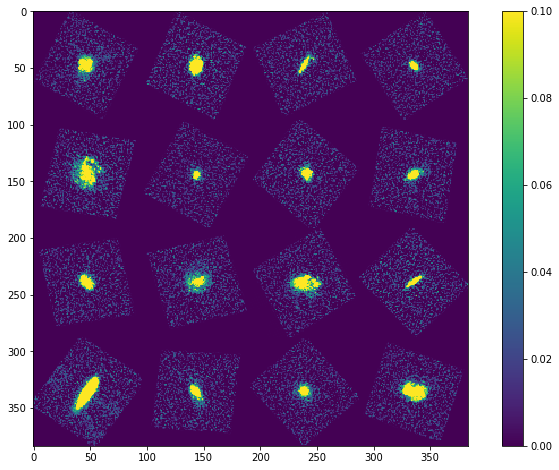

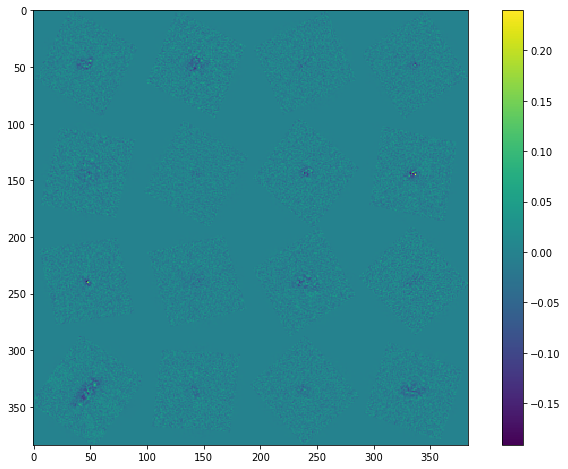

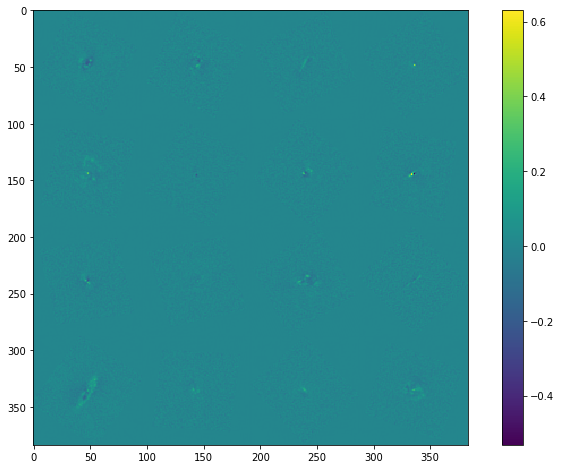

In [12]:
import numpy as np
testc=(slice(0,384),slice(0,384))
target=fits.getdata("/data/DeepDeconv/benchmark/euclidpsf/images/image-shfl-0-multihdu-target_fwhm0p07.fits")
plt.figure(),plt.imshow(target[testc],vmin=0,vmax=0.1),plt.colorbar()

mosaic20=fits.getdata("/data/DeepDeconv/benchmark/euclidpsf/images/image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskGCV_regDirac_regfrac0p1_reshfl_SNR20to100_testSNR20.fits")
#plt.figure(),plt.imshow(mosaic20[testc],vmin=0,vmax=0.1),plt.colorbar()
#plt.figure(),plt.imshow(target[testc]-mosaic20[testc]),plt.colorbar()
#mosaic100=fits.getdata("/data/DeepDeconv/benchmark/euclidpsf/images/image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskGCV_regDirac_regfrac0p1_reshfl_SNR20to100_testSNR100.fits")
#plt.figure(),plt.imshow(mosaic100[testc]),plt.colorbar()
plt.figure(),plt.imshow(target[testc]-mosaic20[testc]),plt.colorbar()
print(np.linalg.norm(mosaic20-target))

mosaic20=fits.getdata("/data/DeepDeconv/benchmark/euclidpsf/images/image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskSurePred_regDirac_reshfl_SNR20to100_testSNR20.fits")
#plt.figure(),plt.imshow(mosaic20[testc],vmin=0,vmax=0.1),plt.colorbar()
plt.figure(),plt.imshow(target[testc]-mosaic20[testc]),plt.colorbar()

print(np.linalg.norm(mosaic20-target))

# Now clear the networks

In [11]:
if 'dnn' in locals():
    print("Clear {0}".format(dnn.network_name))
    del dnn
backk.clear_session()



In [12]:
import gc
gc.collect()

1013216

## Compute Pixel Error

In [9]:
import sharedmem as sm
AFFINITY_FLAG = False

def sharedmem_pool(total_cores):
    # see https://stackoverflow.com/questions/15639779
    global AFFINITY_FLAG
    if not AFFINITY_FLAG:
        AFFINITY_FLAG = True
        os.system("taskset -p 0xfff %d" % os.getpid())
    if total_cores is None:
        total_cores = sm.cpu_count()//2
    return sm.MapReduce(np=total_cores) # No more than 2 cores used



def thr_compute_pixel_error(target_data, restore_data, gal_dim=96, gal_index=np.arange(10000),nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1)):
    '''
    X: ground truth
    Y: estimated images
    '''
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    DIFF=target_data-restore_data
    err = []
    for i in gal_index:
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        if gal_dim == 96:
            err.append((np.linalg.norm((DIFF[x:x+gal_dim,y:y+gal_dim])[xslice, 
                        yslice])**2)/(np.linalg.norm(target_data[x:x+gal_dim,y:y+gal_dim][xslice, yslice])**2))
        else:
            err.append((np.linalg.norm(DIFF[x:x+gal_dim,y:y+gal_dim])**2)/(np.linalg.norm(target_data[x:x+gal_dim,y:y+gal_dim])**2))
    return err


In [10]:
# import glob,os,fnmatch
# testset_file = 'image-shfl-0-multihdu.fits'
# target_name="images/target-shfl-0-multihdu.fits"
# net_path= '/home/fsureau/programs/DeepDeconv/'

# net_file_list=fnmatch.filter(os.listdir(net_path),'*.hdf5')
# net_file_list.sort()

# SNR_list_sim=[20,40,60,80,100]

# write_path="/data/DeepDeconv/benchmark/euclidpsf/"
# for net_file in net_file_list:
#     print(net_file)
#     for SNR_sim in SNR_list_sim:
#         mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
#         if os.path.isfile(write_path+'images/'+mosaic_name):
#             write_txt_name=write_path+'stats/'+mosaic_name.replace('.fits','_pixelerr.txt')
#             if not os.path.isfile(write_txt_name):
#                 print("Compute Pixel error {0}".format(mosaic_name) )
#                 err=compute_pixel_error(write_path+target_name, 0, write_path+'images/'+mosaic_name, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1))
#                 np.savetxt(write_txt_name,np.array(err))
#             else:
#                 err=np.loadtxt(write_txt_name)
#             print("SNR=",SNR_sim,"MEAN_ERR=",np.median(err),"MEDIAN_ERR=",np.median(err))
#         else:
#             print("not existing {0}".format(mosaic_name) )
            
#         def work(i):
#             spect_norm = np.linalg.norm(spectrograms[i])
#             fourier_norms[i] = spect_norm
#             space_norms[i] = spect_norm / math.sqrt(spectrograms[i].size)

#         pool.map(work, list(range(len(spectrograms))))
            


In [11]:
import glob,os,fnmatch
testset_file = 'image-shfl-0-multihdu.fits'
target_name="images/image-shfl-0-multihdu-target_fwhm0p07.fits"
net_path= '/home/fsureau/programs/DeepDeconv/nets/'

net_file_list=fnmatch.filter(os.listdir(net_path),'*.hdf5')
net_file_list.sort()

SNR_list_sim=[20,40,60,80,100]

write_path="/data/DeepDeconv/benchmark/euclidpsf/"

def work(i):
    start_index=i*10000//pool.np
    end_index=(i+1)*10000//pool.np
    print("Process {0}:[{1}-{2}[".format(i,start_index,end_index))
    gal_index=np.arange(start_index,end_index)
    err[start_index:end_index]=thr_compute_pixel_error(target_data, restore_data, gal_dim=96, gal_index=gal_index,nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1))


total_cores=sm.cpu_count()//2
for net_file in net_file_list:
    print(net_file)
    for SNR_sim in SNR_list_sim:
        mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
        if os.path.isfile(write_path+'images/'+mosaic_name):
            write_txt_name=write_path+'stats/'+mosaic_name.replace('.fits','_pixelerr_thr.txt')
            if not os.path.isfile(write_txt_name):
                target_data=fits.getdata(write_path+target_name)
                restore_data=fits.getdata(write_path+'images/'+mosaic_name)
                #print("Compute Pixel error {0}-{1}".format(write_path+'images/'+mosaic_name,write_path+target_name) )
                print("Compute Pixel error {0}".format(mosaic_name) )

                err=sm.empty(10000, dtype='f8')
                with sharedmem_pool(total_cores) as pool:
                    pool.map(work,  list(range(pool.np)))
                np.savetxt(write_txt_name,np.array(err))
            else:
                err=np.loadtxt(write_txt_name)
            print("SNR=",SNR_sim,"MEAN_ERR=",np.mean(err),"MEDIAN_ERR=",np.median(err))
        else:
            print("not existing {0}".format(mosaic_name) )
        


DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100.hdf5
SNR= 20 MEAN_ERR= 0.16475755032729875 MEDIAN_ERR= 0.1546698537819034
SNR= 40 MEAN_ERR= 0.1291117091088817 MEDIAN_ERR= 0.1176629842777012
SNR= 60 MEAN_ERR= 0.11582077494649022 MEDIAN_ERR= 0.10470664615332845
SNR= 80 MEAN_ERR= 0.1080033862420928 MEDIAN_ERR= 0.09682669408054391
SNR= 100 MEAN_ERR= 0.10272691605691082 MEDIAN_ERR= 0.09226503233341643
DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100.hdf5
SNR= 20 MEAN_ERR= 0.16173035606494285 MEDIAN_ERR= 0.15178229720001604
SNR= 40 MEAN_ERR= 0.1277033696852865 MEDIAN_ERR= 0.11610745793922872
SNR= 60 MEAN_ERR= 0.11504851127151164 MEDIAN_ERR= 0.1027031862248386
SNR= 80 MEAN_ERR= 0.10860917000597099 MEDIAN_ERR= 0.09606153330168321
SNR= 100 MEAN_ERR= 0.10495943773938375 MEDIAN_ERR= 0.09188616278013079
DeconvNet2D_FCS_sc4_layer4x5x6x7_relu_growthRate12_reshfl_SNR20to100.hdf5
SNR= 20 MEAN_ERR= 0.16057408600082163 MEDIAN_ERR= 0.1506473588

SNR= 80 MEAN_ERR= 0.2369684659627298 MEDIAN_ERR= 0.2260510283421881
SNR= 100 MEAN_ERR= 0.30053615015697177 MEDIAN_ERR= 0.2674745718591224
DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskSurePred_regDirac_reshfl_SNR20to100.hdf5
SNR= 20 MEAN_ERR= 0.16605249024146673 MEDIAN_ERR= 0.15604103526431723
SNR= 40 MEAN_ERR= 0.1283443113591121 MEDIAN_ERR= 0.11695337926825689
SNR= 60 MEAN_ERR= 0.11454447922311399 MEDIAN_ERR= 0.10351791506659827
SNR= 80 MEAN_ERR= 0.10564218283450844 MEDIAN_ERR= 0.09490263357046796
SNR= 100 MEAN_ERR= 0.10002033391295007 MEDIAN_ERR= 0.08991102492806712
DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskSureProj_regDirac_tole-12_reshfl_SNR20to100.hdf5
SNR= 20 MEAN_ERR= 8.213329764076049 MEDIAN_ERR= 0.7368857524726002
SNR= 40 MEAN_ERR= 2.490764504545436 MEDIAN_ERR= 0.4778277702717196
SNR= 60 MEAN_ERR= 1.2415896412941132 MEDIAN_ERR= 0.3719624178724596
SNR= 80 MEAN_ERR= 0.8680261516957273 MEDIAN_ERR= 0.3147419474588349
SNR= 100 MEAN_ERR= 0.655390655002353 MED

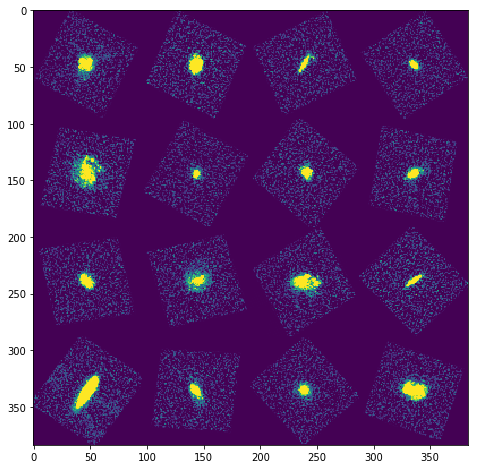

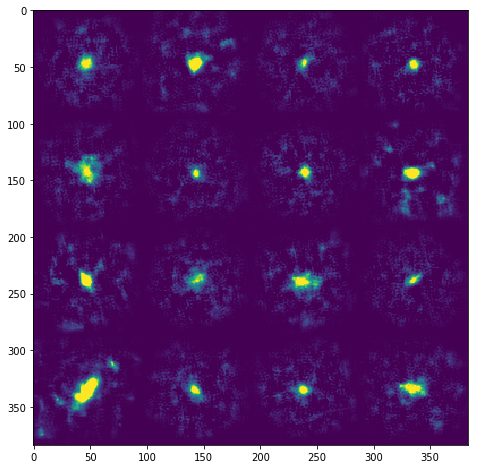

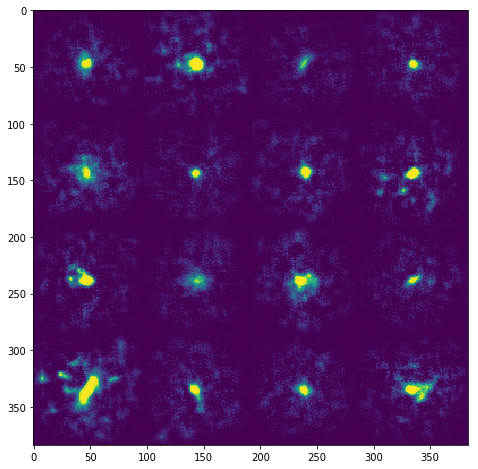

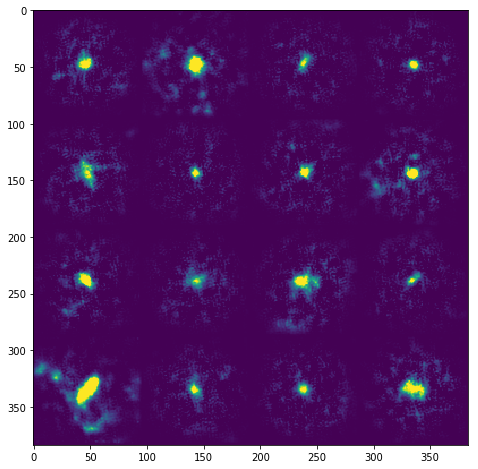

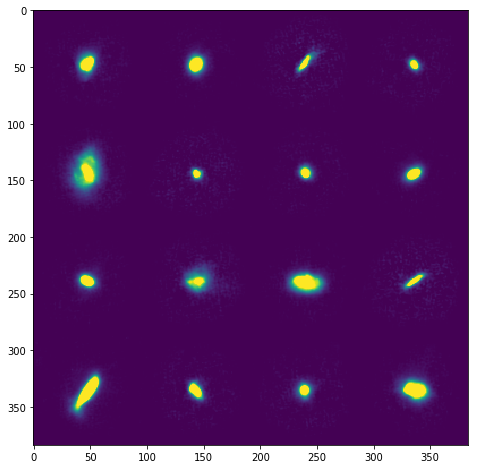

In [19]:
SNR_sim=20
net_file_list=["DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskGCV_regDirac_regfrac0p001_reshfl_SNR20to100.hdf5","DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskGCV_regDirac_regfrac0p01_reshfl_SNR20to100.hdf5","DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskGCV_regDirac_regfrac0p1_reshfl_SNR20to100.hdf5","DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskGCV_regDirac_reshfl_SNR20to100.hdf5"]
target=fits.getdata("/data/DeepDeconv/benchmark/euclidpsf/images/image-shfl-0-multihdu-target_fwhm0p07.fits")
plt.imshow(target[0:384,0:384],vmin=0,vmax=0.1)
for net_file in net_file_list:
    plt.figure()
    mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
    restore_data=fits.getdata(write_path+'images/'+mosaic_name)
    plt.imshow(restore_data[0:384,0:384],vmin=0,vmax=0.1)
    
    

## Compute Ellipticity Error

In [9]:
#Create Mosaic and save it
testset_file = 'image-shfl-0-multihdu.fits'
target_name=testset_file.replace('.fits','-target_fwhm0p07.fits')
write_path="/data/DeepDeconv/benchmark/euclidpsf/"
save_weights=write_path+'ellip/'+target_name.replace('.fits','_weights.fits')

#perform target ellipticity measurements
psf_file="/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits"
ellip_filename=write_path+'ellip/'+target_name.replace('.fits','_ellipmes.fits')
#fast_generate_shape_txt(write_path+'images/'+target_name, psf_file, ellip_filename, mosaic_size=100, save_weights=save_weights, weights_input='-o')
#generate_shape_txt(write_path+'images/'+target_name, psf_file, ellip_filename, mosaic_size=100, save_weights=save_weights, weights_input='-o')

In [10]:
a_fits= get_ellipticity('/data/DeepDeconv/benchmark/euclidpsf/ellip/image-shfl-0-multihdu-target_fwhm0p07_ellipmes.fits')
a_txt= get_ellipticity('/data/DeepDeconv/benchmark/euclidpsf/ellip/image-shfl-0-multihdu-target_fwhm0p07_ellipmes.txt')
np.max(np.abs(a_fits-a_txt))



4.7683716e-06

In [11]:
#psf_file="/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits"
#ellip_filename=write_path+'ellip/'+target_name.replace('.fits','_ellipmes.fits')
#save_weights=write_path+'ellip/'+target_name.replace('.fits','_weights.fits')
#SNR_list_sim=[20,40,60,80,100]
#for SNR_sim in SNR_list_sim:
#     mosaic_name=target_name.replace('.fits','_SNR{0}.fits'.format(SNR_sim))
#     ellip_filename=write_path+'ellip/'+mosaic_name.replace('.fits','_ellipmes_targetweights.fits')
#     fast_generate_shape_txt(write_path+'images/'+mosaic_name, psf_file, ellip_filename, mosaic_size=100, save_weights=save_weights, weights_input='-i')

In [12]:
# psf_file="/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits"
# ellip_filename=write_path+'ellip/'+target_name.replace('.fits','_ellipmes.txt')

# SNR_list_sim=[20,40,60,80,100]
# for SNR_sim in SNR_list_sim:
#     mosaic_name=target_name.replace('.fits','_SNR{0}.fits'.format(SNR_sim))
#     ellip_filename=write_path+'ellip/'+mosaic_name.replace('.fits','_ellipmes_targetweights_SNR{0}.txt'.format(SNR_sim))
#     save_weights=write_path+'ellip/'+target_name.replace('.fits','_weights_SNR{0}.fits'.format(SNR_sim))
# #     generate_shape_txt(write_path+'images/'+mosaic_name, psf_file, ellip_filename, mosaic_size=100, save_weights=save_weights, weights_input='-o')

In [12]:
import glob,os,fnmatch
testset_file = 'image-shfl-0-multihdu.fits'
net_path= '/home/fsureau/programs/DeepDeconv/nets'
target_name=testset_file.replace('.fits','-target_fwhm0p07.fits')
psf_file="/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits"

net_file_list=fnmatch.filter(os.listdir(net_path),'*.hdf5')
net_file_list.sort()

SNR_list_sim=[20,40,60,80,100]

# Create the set of test with 10 observations at SNR 50
write_path="/data/DeepDeconv/benchmark/euclidpsf/"
    
used_cores=np.min((len(SNR_list_sim),sm.cpu_count()-2))  

for net_file in net_file_list:
    print(net_file)
    with sharedmem_pool(used_cores) as pool:
        def work(i):
            SNR_sim=SNR_list_sim[i]
            mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
            if os.path.isfile(write_path+'images/'+mosaic_name):
                ellip_filename=write_path+'ellip/'+mosaic_name.replace('.fits','_ellipmes_targetweights.fits'.format(SNR_sim))
                save_weights=write_path+'ellip/'+target_name.replace('.fits','_weights.fits')
                if not os.path.isfile(ellip_filename):
                    with pool.critical:
                        print("Compte Ellip {0}".format(mosaic_name) )
                    cmd_file = '../scripts/fast_get_shape/get_shape_{0}.cmd'.format(mosaic_name.replace('.fits','_ellipmes_targetweights'))
                    fast_generate_shape_txt(write_path+'images/'+mosaic_name, psf_file, ellip_filename,cmd_file=cmd_file, mosaic_size=100, save_weights=save_weights, weights_input='-i')
            else:
                with pool.critical:
                    print("not existing {0}".format(mosaic_name) )
        pool.map(work, range(len(SNR_list_sim)))
    



DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100.hdf5
DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100.hdf5
DeconvNet2D_FCS_sc4_layer4x5x6x7_relu_growthRate12_reshfl_SNR20to100.hdf5
DeconvNet2D_FCS_sc4_layer4x5x6x7_swish_growthRate12_reshfl_SNR20to100.hdf5
DeconvNet2D_FCS_sc4_layer5x5x5x5_relu_growthRate12_reshfl_SNR20to100.hdf5
DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_reshfl_SNR20to100.hdf5
DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskGCV_regDirac_regfrac0p01_reshfl_SNR20to100.hdf5
Compte Ellip image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskGCV_regDirac_regfrac0p01_reshfl_SNR20to100_testSNR20.fits
/data/shapelens_v2/shapelens-CEA-master/bin/get_shapes_output -i /data/DeepDeconv/benchmark/euclidpsf/ellip/image-shfl-0-multihdu-target_fwhm0p07_weights.fits -p /data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits -g 100 -s 96 -T /data/DeepDeconv/benchmark/euclidpsf/im

DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskGCV_regDirac_regfrac10_reshfl_SNR20to100.hdf5
Compte Ellip image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskGCV_regDirac_regfrac10_reshfl_SNR20to100_testSNR20.fits
/data/shapelens_v2/shapelens-CEA-master/bin/get_shapes_output -i /data/DeepDeconv/benchmark/euclidpsf/ellip/image-shfl-0-multihdu-target_fwhm0p07_weights.fits -p /data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits -g 100 -s 96 -T /data/DeepDeconv/benchmark/euclidpsf/images/image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskGCV_regDirac_regfrac10_reshfl_SNR20to100_testSNR20.fits /data/DeepDeconv/benchmark/euclidpsf/ellip/image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskGCV_regDirac_regfrac10_reshfl_SNR20to100_testSNR20_ellipmes_targetweights.fits
Compte Ellip image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskGCV_regDirac_regfrac10_reshfl_SNR20to100

DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskSurePred_regDirac_reshfl_SNR20.hdf5
DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskSurePred_regDirac_reshfl_SNR20to100.hdf5
DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskSureProj_regDirac_tole-12_reshfl_SNR20to100.hdf5
DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskSureProj_regDirac_tole-3_reshfl_SNR20to100.hdf5
DeconvNet2D_FCS_sc4_layer7x6x5x4_relu_growthRate12_reshfl_SNR20to100.hdf5
DeconvNetRef_FCS_train2to20_val1_vsc_rangeSNR20to100.hdf5
UNet2D_FCS_sc2_layer2x2_relu_filt8_resNet.hdf5
UNet2D_FCS_sc3_layer4x4x4_relu_filt16_atrou_reshfl_SNR20to100.hdf5
UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet_SNR100.hdf5
UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet_reshfl_SNR20to100.hdf5
UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100.hdf5


In [14]:
import glob,os,fnmatch
testset_file = 'image-shfl-0-multihdu.fits'
net_path= '/home/fsureau/programs/DeepDeconv/nets'
target_name=testset_file.replace('.fits','-target_fwhm0p07.fits')
psf_file="/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits"
ellip_filename_ref=write_path+'ellip/'+target_name.replace('.fits','_ellipmes.fits')

net_file_list=fnmatch.filter(os.listdir(net_path),'*.hdf5')
net_file_list.sort()

SNR_list_sim=[20,40,60,80,100]

# Create the set of test with 10 observations at SNR 50
write_path="/data/DeepDeconv/benchmark/euclidpsf/"
    
used_cores=np.min((len(SNR_list_sim),sm.cpu_count()-2))  

for net_file in net_file_list:
    print(net_file)
    with sharedmem_pool(1) as pool:
        def work(i):
            SNR_sim=SNR_list_sim[i]
            mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
            if os.path.isfile(write_path+'images/'+mosaic_name):
                ellip_filename=write_path+'ellip/'+mosaic_name.replace('.fits','_ellipmes_targetweights.fits'.format(SNR_sim))
                if os.path.isfile(ellip_filename):
                    with pool.critical:
                        print("Compte Ellip error {0}".format(mosaic_name) )
                        ell_err=compute_ellipticity_error(ellip_filename_ref, ellip_filename, plot_hist=False, max_idx=10000)
                        print("SNR=",SNR_sim,"MEAN_ERR=",np.mean(ell_err),"MEDIAN_ERR=",np.median(ell_err))
            else:
                with pool.critical:
                    print("not existing {0}".format(mosaic_name) )

        pool.map(work, range(len(SNR_list_sim)))
    



DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100.hdf5
Compte Ellip error image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100_testSNR20.fits
SNR= 20 MEAN_ERR= 0.12259844 MEDIAN_ERR= 0.11016882
Compte Ellip error image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100_testSNR40.fits
SNR= 40 MEAN_ERR= 0.07107751 MEDIAN_ERR= 0.06179953
Compte Ellip error image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100_testSNR60.fits
SNR= 60 MEAN_ERR= 0.051681712 MEDIAN_ERR= 0.044577777
Compte Ellip error image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100_testSNR80.fits
SNR= 80 MEAN_ERR= 0.041956495 MEDIAN_ERR= 0.0356402
Compte Ellip error image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR

SNR= 20 MEAN_ERR= 0.22509308 MEDIAN_ERR= 0.19638458
Compte Ellip error image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskGCV_regLap_reshfl_SNR20to100_testSNR40.fits
SNR= 40 MEAN_ERR= 0.17704241 MEDIAN_ERR= 0.1521
Compte Ellip error image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskGCV_regLap_reshfl_SNR20to100_testSNR60.fits
SNR= 60 MEAN_ERR= 0.14585106 MEDIAN_ERR= 0.123043016
Compte Ellip error image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskGCV_regLap_reshfl_SNR20to100_testSNR80.fits
SNR= 80 MEAN_ERR= 0.12302483 MEDIAN_ERR= 0.10349246
Compte Ellip error image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskGCV_regLap_reshfl_SNR20to100_testSNR100.fits
SNR= 100 MEAN_ERR= 0.103469454 MEDIAN_ERR= 0.086042285
DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_growthRate12_riskSurePred_regDirac_reshfl_SNR20.hdf5
Compte Ellip error image-shfl-0-multihdu-DeconvNet2D_FCS_sc4_layer5x5x5x5_swish_gro

SNR= 100 MEAN_ERR= 0.037962027 MEDIAN_ERR= 0.03182554
UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100.hdf5
Compte Ellip error image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100_testSNR20.fits
SNR= 20 MEAN_ERR= 0.12158902 MEDIAN_ERR= 0.10960342
Compte Ellip error image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100_testSNR40.fits
SNR= 40 MEAN_ERR= 0.07052934 MEDIAN_ERR= 0.06152388
Compte Ellip error image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100_testSNR60.fits
SNR= 60 MEAN_ERR= 0.051716775 MEDIAN_ERR= 0.04435763
Compte Ellip error image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100_testSNR80.fits
SNR= 80 MEAN_ERR= 0.041391395 MEDIAN_ERR= 0.03496415
Compte Ellip error image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100_testSNR100.fits
SNR= 100 MEAN_ERR= 0.036700338 MEDIAN_ERR= 0.03023614


(<matplotlib.axes._subplots.AxesSubplot at 0x7f6e42b11ef0>,
 <matplotlib.colorbar.Colorbar at 0x7f6e42a9b898>)

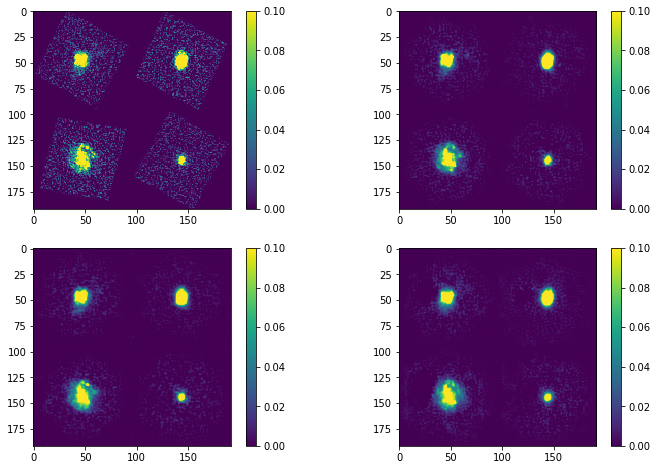

In [63]:
#Explore various results:
write_path="/data/DeepDeconv/benchmark/euclidpsf/"
target_name=testset_file.replace('.fits','-target_fwhm0p07.fits')
SNR=100
target=fits.getdata(write_path+'images/'+target_name)
unet4x4x4_name=write_path+"images/image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100_testSNR{0}.fits".format(SNR)
unet4x4x4=fits.getdata(unet4x4x4_name)
unet4x4x4_res_name=write_path+"images/image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet_reshfl_SNR20to100_testSNR{0}.fits".format(SNR)
unet4x4x4_res=fits.getdata(unet4x4x4_res_name)
deconvnet_name=write_path+"images/image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100_testSNR{0}.fits".format(SNR)
deconvnet=fits.getdata(deconvnet_name)

plt.subplot(2,2,1),plt.imshow(target[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()
plt.subplot(2,2,2),plt.imshow(unet4x4x4[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()
plt.subplot(2,2,3),plt.imshow(unet4x4x4_res[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()
plt.subplot(2,2,4),plt.imshow(deconvnet[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()


In [ ]:
if 'dnn' in locals():
    del dnn
k.clear_session()
